In [ ]:
# Author: Yuki Rivera
# This notebook contains the code to build and train a basic transformer model in PyTorch.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Sets the file paths

In [ ]:
trial = "3rd_10k/"
path = "/content/drive/path/to/project/"
output_dir = path + trial + "results"

### Imports necessary libraries

In [ ]:
from collections import Counter
import re
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import time
import zipfile
import pickle

### Global Variables

In [ ]:
# Special tokens
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"
BOS_TOKEN = "<bos>"
EOS_TOKEN = "<eos>"

### Hyperparameters used for training

In [ ]:
full_data = False

# number of rows for testing
data_size = 10000
# Number of epochs
epochs = 60
# batch size
batch_size = 16  
# Patience for early stopping
patience = 2

vocab_length = 8000 

# Set the minimum to remove rare words from vocab
minimum_frequency = 2 

# max prompt length
input_len = 50
# max synopsis length
output_len = 150

vocab_size = vocab_length
# embedding + hidden dimension size
d_model_size = 128 
# Number of attention heads
num_head = 2 
# Number of encoder-decoder layers
layers = 2 
# size of feedforward hidden layer
forward_dim = 2 * d_model_size
# Regularization (dropout probability)
dropout_prob = 0.1 
# Max sequence length for positional encoding
seq_length = 30 

# learning rate
alpha = 1e-4


### Function Definitions

In [ ]:
# Manual tokenizer 
def tokenize(text):
    # cleans the text
    text = re.sub(r"[^\w\s]", "", text.lower())
    return text.strip().split()

# Builds a vocabulary dictionary
def build_vocab(dataset, min_freq=minimum_frequency, max_size=vocab_length):

    # counts how many times each token appears in the dataset
    counter = Counter()
    for text in dataset:
        tokens = tokenize(text)
        counter.update(tokens)

    # initializes the vocab with special tokens
    vocab = {PAD_TOKEN: 0, UNK_TOKEN: 1, BOS_TOKEN: 2, EOS_TOKEN: 3}

    # goes through the most frequent words first, then adds only those with
    # more than the min frequency and stops when vocabulary max_size is reached
    index = 4
    for word, freq in counter.most_common():
        if freq >= min_freq and len(vocab) < max_size:
            vocab[word] = index
            index += 1
    return vocab

# Converts a text string into a fixed-length list of token IDs
def encode(text, vocab, max_len):

    tokens = [BOS_TOKEN] + tokenize(text) + [EOS_TOKEN]
    # looks up each token's id in the vocab (if not found, use unk)
    ids = [vocab.get(t, vocab[UNK_TOKEN]) for t in tokens]
    # truncates or pads based on the max_len
    ids = ids[:max_len] + [vocab[PAD_TOKEN]] * max(0, max_len - len(ids))
    return ids


### Function to preprocess the dataset for batching with a PyTorch dataloader

In [ ]:
class PromptSynopsisDataset(Dataset):
    def __init__(self, prompts, synopses, vocab, max_input_len, max_output_len):
        self.prompts = prompts
        self.synopses = synopses
        self.vocab = vocab
        self.max_input_len = max_input_len
        self.max_output_len = max_output_len

    def __len__(self):
        return len(self.prompts)

    # returns tokenized prompt and synopsis as tensors
    def __getitem__(self, idx):
        prompt = self.prompts[idx]
        synopsis = self.synopses[idx]
        input_ids = encode(prompt, self.vocab, self.max_input_len)
        target_ids = encode(synopsis, self.vocab, self.max_output_len)
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'target_ids': torch.tensor(target_ids, dtype=torch.long)
        }

### Function to wrap the data into a PyTorch dataset and returns a dataloader

In [ ]:
def get_dataloader(prompts, synopses, vocab, batch_size=batch_size, max_input_len=input_len, max_output_len=output_len):
    dataset = PromptSynopsisDataset(prompts, synopses, vocab, max_input_len, max_output_len)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Loads Input/Output Pairs

In [ ]:
df = pd.read_csv(path + "/prompt_synopsis_train.csv")

if not full_data:
    sampled_df = df.sample(n=data_size, random_state=42).reset_index(drop=True)
else:
    sampled_df = df

prompts = sampled_df["prompt"].tolist()
synopses = sampled_df["synopsis"].tolist()

### Splits the data into training and validation sets

In [ ]:
train_prompts, val_prompts, train_synopses, val_synopses = train_test_split(
    prompts, synopses, test_size=0.2, random_state=42)

### Sets the device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Builds the Vocabulary

In [ ]:
all_texts = prompts + synopses
vocab = build_vocab(all_texts, minimum_frequency, vocab_length)

In [ ]:
# Saves the vocab for evaluation later
with open(output_dir + "/vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

### Define the tranformer model

In [ ]:
class TransformerModel(nn.Module): 
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=2, dim_feedforward=512, dropout=0.1, max_len=50):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = self._build_positional_encoding(max_len, d_model)

        # encoder-decoder layer with multi-head self-attention, feedforward network with layernorm + dropout
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)

        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.fc_out = nn.Linear(d_model, vocab_size)

    # Creates sine/cosine positional encodings
    def _build_positional_encoding(self, max_len, d_model):

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model))
        # fills even-numbered dimensions with sin()
        pe[:, 0::2] = torch.sin(position * div_term)
        # fills odd-numbered dimensions with cos()
        pe[:, 1::2] = torch.cos(position * div_term)

        return pe.unsqueeze(0)  # shape: (1, max_len, d_model)


    def forward(self, src, tgt):

        # embeds the prompt/target using learned embeddings and adds positional encoding for each token's position
        src_embed = self.embedding(src) + self.positional_encoding[:, :src.size(1), :].to(src.device)
        tgt_embed = self.embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :].to(tgt.device)

        # feeds the prompt/target into the transformer encoder/decoder
        memory = self.encoder(src_embed)
        output = self.decoder(tgt_embed, memory)

        # applies a final linear layer to convert decoder outputs into logits over the vocab
        return self.fc_out(output)

### Initializes the model

In [ ]:
model = TransformerModel(
    vocab_size=len(vocab),
    d_model=d_model_size,
    nhead=num_head,
    num_layers=layers,
    dim_feedforward=forward_dim,
    dropout=dropout_prob,
    max_len=max(input_len, output_len)
).to(device)

### Set up training components

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=vocab[PAD_TOKEN])
optimizer = torch.optim.Adam(model.parameters(), lr=alpha)

### Prepare DataLoader

In [ ]:
train_loader = get_dataloader(train_prompts, train_synopses, vocab, batch_size=16, max_input_len=50, max_output_len=150)
val_loader = get_dataloader(val_prompts, val_synopses, vocab, batch_size=16, max_input_len=50, max_output_len=150)

### Function to run one full epoch over the data

In [ ]:
def run_epoch(model, dataloader, loss_fn, device, optimizer=None):

    is_training = optimizer is not None
    total_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for batch in dataloader:
        src = batch["input_ids"].to(device)  
        tgt = batch["target_ids"].to(device) 

        # removes the last token (for decoder input)
        tgt_input = tgt[:, :-1]
        # removes the first token (for expected output)
        tgt_expected = tgt[:, 1:]

        if is_training:
            # resets gradients
            optimizer.zero_grad()

        with torch.set_grad_enabled(is_training):
            # forward pass 
            output = model(src, tgt_input)
            # flatten the output
            output = output.reshape(-1, output.shape[-1])
            # flatten the target 
            tgt_expected = tgt_expected.reshape(-1)

            # computes loss
            loss = loss_fn(output, tgt_expected)

            if is_training:
                # backpropagation
                loss.backward()
                # update weights
                optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss


### Function to train the model over multiple epochs

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn,
                num_epochs=5, patience=3, device="cuda", save_path=None):

    model.to(device)
    train_losses, val_losses = [], []

    best_val_loss = float("inf")
    wait = 0

    for epoch in range(num_epochs):
        train_loss = run_epoch(model, train_loader, loss_fn, device, optimizer)
        val_loss = run_epoch(model, val_loader, loss_fn, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        train_perplexity = math.exp(train_loss)
        val_perplexity = math.exp(val_loss)

        print(f"Epoch {epoch+1}: "
                f"Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f} | "
                f"Train PPL = {train_perplexity:.2f}, Val PPL = {val_perplexity:.2f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
            # Saves the model only when the validation loss improves
            if save_path:
                torch.save(model.state_dict(), save_path)
                print(f"Saved model weights to {save_path}")

        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    return train_losses, val_losses


### Train the model and calculates the validation perplexity

In [ ]:
# Create the output directory
os.makedirs(output_dir, exist_ok=True)

train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs, patience, device=device, save_path=output_dir + "/transformer_model.pt")

final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]

final_train_perplexity = math.exp(final_train_loss)
final_val_perplexity = math.exp(final_val_loss)

print(f"Final Train Perplexity: {final_train_perplexity:.2f}")
print(f"Final Val Perplexity: {final_val_perplexity:.2f}")


Epoch 1: Train Loss = 6.8725, Val Loss = 6.3464 | Train PPL = 965.35, Val PPL = 570.46
Saved model weights to /content/drive/My Drive/BC_CS/CS495_Capstone/notebooks/StoryGeneration/BasicTransformer/3rd_10k/results/transformer_model.pt
Epoch 2: Train Loss = 6.2269, Val Loss = 6.1047 | Train PPL = 506.18, Val PPL = 447.94
Saved model weights to /content/drive/My Drive/BC_CS/CS495_Capstone/notebooks/StoryGeneration/BasicTransformer/3rd_10k/results/transformer_model.pt
Epoch 3: Train Loss = 6.0286, Val Loss = 5.9387 | Train PPL = 415.12, Val PPL = 379.46
Saved model weights to /content/drive/My Drive/BC_CS/CS495_Capstone/notebooks/StoryGeneration/BasicTransformer/3rd_10k/results/transformer_model.pt
Epoch 4: Train Loss = 5.8689, Val Loss = 5.7896 | Train PPL = 353.88, Val PPL = 326.90
Saved model weights to /content/drive/My Drive/BC_CS/CS495_Capstone/notebooks/StoryGeneration/BasicTransformer/3rd_10k/results/transformer_model.pt
Epoch 5: Train Loss = 5.7136, Val Loss = 5.6164 | Train PPL 

### Plot the loss curve

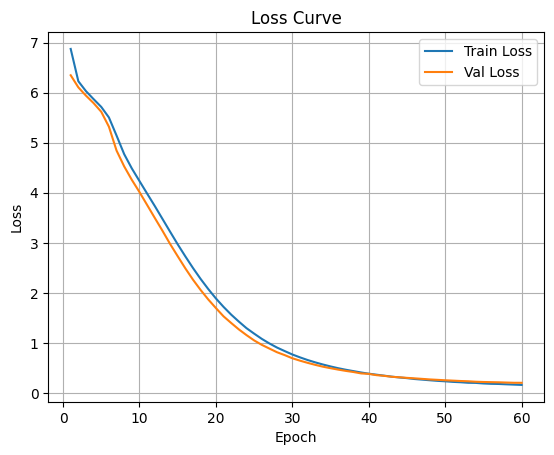

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig(output_dir + "/loss_curve.png")
plt.show()


### Plot the perplexity curve

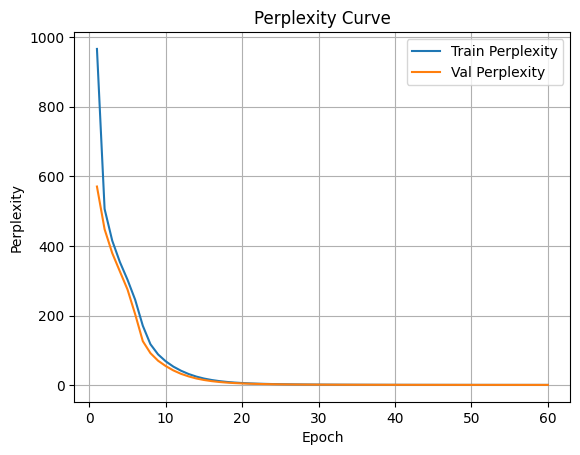

In [ ]:
train_perplexities = [math.exp(loss) for loss in train_losses]
val_perplexities = [math.exp(loss) for loss in val_losses]

plt.plot(epochs, train_perplexities, label="Train Perplexity")
plt.plot(epochs, val_perplexities, label="Val Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Perplexity Curve")
plt.legend()
plt.grid(True)
plt.savefig(output_dir + "/perplexity_curve.png")
plt.show()
